# Create maps for small regions

Run this notebook in Google Colab.

## Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/alexvmt/openmapflow.git

Cloning into 'openmapflow'...
remote: Enumerating objects: 4626, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 4626 (delta 8), reused 13 (delta 6), pack-reused 4604
Receiving objects: 100% (4626/4626), 181.92 MiB | 35.05 MiB/s, done.
Resolving deltas: 100% (3077/3077), done.


In [3]:
%cd '/content/drive/MyDrive/openmapflow/kaza-bengo-crop'

/content/drive/MyDrive/openmapflow/kaza-bengo-crop


In [4]:
!pip install openmapflow[all]==0.2.2rc1 -q
!pip install rioxarray

     |████████████████████████████████| 88 kB 3.5 MB/s 
     |████████████████████████████████| 1.1 MB 38.5 MB/s 
     |████████████████████████████████| 272 kB 61.4 MB/s 
     |████████████████████████████████| 76 kB 4.7 MB/s 
     |████████████████████████████████| 20.9 MB 1.5 MB/s 
     |████████████████████████████████| 223 kB 57.7 MB/s 
     |████████████████████████████████| 7.8 MB 71.0 MB/s 
     |████████████████████████████████| 16.6 MB 53.7 MB/s 
     |████████████████████████████████| 1.6 MB 64.9 MB/s 
     |████████████████████████████████| 2.5 MB 52.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.4 MB/s 


In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path

import rasterio as rio
import rioxarray
import cmocean

from openmapflow.config import PROJECT
from openmapflow.inference import Inference

import torch

In [6]:
model_name = 'small_regions_maps_test'
model_path = f'data/models/{model_name}.pt'
region = 'min_lat=-16.69_min_lon=23.54_max_lat=-16.64_max_lon=23.6'
dates = 'dates=2020-01-01_2021-01-01'
map_name = 'sioma_crop_map_2020'

## Check out model performance

### Prerequisites

Model needs to be trained prior to running this notebook.

In [7]:
# check out which datasets were used to train the model used in this notebook
!openmapflow datasets

DATASET REPORT (autogenerated, do not edit directly)

GeowikiLandcover2017 (Timesteps: 24)
----------------------------------------------------------------------------
eo_data_complete          34270
eo_data_export_failed       841
eo_data_missing_values      379
✔ training amount: 34270, positive class: 21.2%



KAZABengoCrop2020Random2000 (Timesteps: 24)
----------------------------------------------------------------------------
eo_data_complete    2000
✔ training amount: 1194, positive class: 49.2%
✔ validation amount: 378, positive class: 54.2%
✔ testing amount: 428, positive class: 48.6%



### Model: small_regions_maps_test

#### Validation set metrics

- accuracy: 0.746
- f1: 0.7419
- precision: 0.8263
- recall: 0.6732
- roc_auc: 0.8237

In [8]:
!python evaluate.py --model_name small_regions_maps_test

Testing:   0%|          | 0/7 [00:00<?, ?it/s]
class_probability:
  0: 0.514018691588785
  1: 0.48598130841121495
test_metrics:
  accuracy: 0.7547
  f1: 0.7382
  precision: 0.7668
  recall: 0.7115
  roc_auc: 0.8519
test_size: 428



## Load data from Google Cloud

### Prerequisites

Make sure all inference files in the respective Google Cloud buckets are public, e. g.

`gsutil acl -r ch -u AllUsers:R gs://kaza-bengo-crop-inference-eo/*`

Make sure to have a text file in Google Drive containing all file paths for the region of interest to be made predictions for, e. g.

`gcloud storage ls --recursive gs://kaza-bengo-crop-inference-eo/kazabengocrop2020random2000/min_lat=-16.69_min_lon=23.54_max_lat=-16.64_max_lon=23.6_dates=2020-01-01_2021-01-01_all/batch_0/**`

Google Cloud authentification required.

In [9]:
tifs_dir = Path(f'/content/tifs')
preds_dir = Path(f'/content/preds')
tifs_dir.mkdir(exist_ok=True)
preds_dir.mkdir(exist_ok=True)

In [10]:
with open(f'../{region}_{dates}_all.txt') as file:
    tifs_paths = file.readlines()
tifs_paths = [i.replace('\n', '') for i in tifs_paths]
len(tifs_paths)

9

In [11]:
tifs_paths[:5]

['gs://kaza-bengo-crop-inference-eo/kazabengocrop2020random2000/min_lat=-16.69_min_lon=23.54_max_lat=-16.64_max_lon=23.6_dates=2020-01-01_2021-01-01_all/batch_0/00000000000-0000000000.tif',
 'gs://kaza-bengo-crop-inference-eo/kazabengocrop2020random2000/min_lat=-16.69_min_lon=23.54_max_lat=-16.64_max_lon=23.6_dates=2020-01-01_2021-01-01_all/batch_0/00000000000-0000000256.tif',
 'gs://kaza-bengo-crop-inference-eo/kazabengocrop2020random2000/min_lat=-16.69_min_lon=23.54_max_lat=-16.64_max_lon=23.6_dates=2020-01-01_2021-01-01_all/batch_0/00000000000-0000000512.tif',
 'gs://kaza-bengo-crop-inference-eo/kazabengocrop2020random2000/min_lat=-16.69_min_lon=23.54_max_lat=-16.64_max_lon=23.6_dates=2020-01-01_2021-01-01_all/batch_0/00000000256-0000000000.tif',
 'gs://kaza-bengo-crop-inference-eo/kazabengocrop2020random2000/min_lat=-16.69_min_lon=23.54_max_lat=-16.64_max_lon=23.6_dates=2020-01-01_2021-01-01_all/batch_0/00000000256-0000000256.tif']

In [12]:
for p in tqdm(tifs_paths):
  !gsutil -m cp {p} {tifs_dir}/{Path(p).name}

  0%|          | 0/9 [00:00<?, ?it/s]

Copying gs://kaza-bengo-crop-inference-eo/kazabengocrop2020random2000/min_lat=-16.69_min_lon=23.54_max_lat=-16.64_max_lon=23.6_dates=2020-01-01_2021-01-01_all/batch_0/00000000000-0000000000.tif...
| [1/1 files][ 47.3 MiB/ 47.3 MiB] 100% Done                                    
Operation completed over 1 objects/47.3 MiB.                                     
Copying gs://kaza-bengo-crop-inference-eo/kazabengocrop2020random2000/min_lat=-16.69_min_lon=23.54_max_lat=-16.64_max_lon=23.6_dates=2020-01-01_2021-01-01_all/batch_0/00000000000-0000000256.tif...
- [1/1 files][ 47.0 MiB/ 47.0 MiB] 100% Done                                    
Operation completed over 1 objects/47.0 MiB.                                     
Copying gs://kaza-bengo-crop-inference-eo/kazabengocrop2020random2000/min_lat=-16.69_min_lon=23.54_max_lat=-16.64_max_lon=23.6_dates=2020-01-01_2021-01-01_all/batch_0/00000000000-0000000512.tif...
- [1/1 files][ 29.0 MiB/ 29.0 MiB] 100% Done                                    
Op

## Make predictions

In [13]:
model = torch.jit.load(model_path)

In [14]:
inference = Inference(model=model, normalizing_dict=None)

In [15]:
local_pred_paths = []

In [16]:
tifs = list(Path(tifs_dir).glob('*.tif'))

In [17]:
for local_tif_path in tqdm(tifs, desc='Making predictions'):
  local_pred_path = Path(f'{preds_dir}/pred_{local_tif_path.stem}.nc')
  inference.run(
      local_path=local_tif_path,
      dest_path=local_pred_path
  )
  local_pred_paths.append(local_pred_path)

Making predictions:   0%|          | 0/9 [00:00<?, ?it/s]

In [18]:
def merge_tifs(full_prefix):
  vrt_in_file = f'{full_prefix}*'
  vrt_out_file = f'{full_prefix}.vrt'
  merged_file = f'{full_prefix}.tif'
  !gdalbuildvrt {vrt_out_file} {vrt_in_file}
  !gdal_translate -a_srs EPSG:4326 -of GTiff {vrt_out_file} {merged_file}
  return merged_file

In [19]:
merged_pred_file = merge_tifs(full_prefix=f'{preds_dir}/')

0...10Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
...20Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
...30.Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
..40.Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
..50..Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
.60..Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
.70...Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
80...Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
90...100 - done.
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Input file size is 668, 558
0Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
...10...20...30...40...50Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA

## Check out predictions

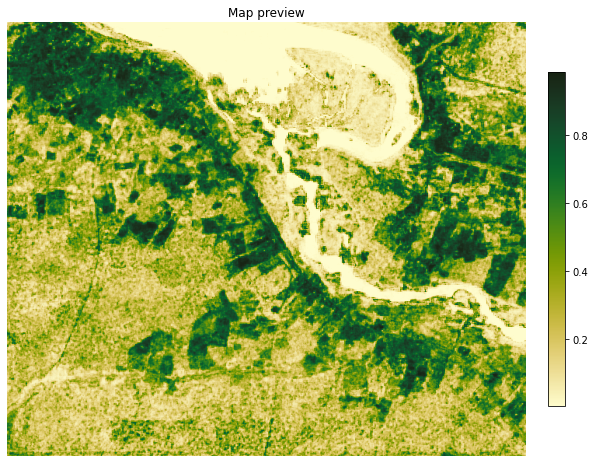

In [20]:
predictions_map = rio.open(merged_pred_file)

if 'maize' in PROJECT:
  cmap = cmocean.cm.solar
  cmap_name = 'Solar'
elif 'crop' in PROJECT:
  cmap = cmocean.cm.speed
  cmap_name = 'Speed'
else:
  cmap = cmocean.cm.thermal
  cmap_name = 'Thermal'

plt.figure(figsize=(10,10))
plt.imshow(predictions_map.read(1).clip(0,1), cmap=cmap)
plt.title('Map preview')
plt.colorbar(fraction=0.03, pad=0.04)
plt.axis('off');

## Transform predictions from NetCDF to GeoTIFF format

In [21]:
rds = rioxarray.open_rasterio('/content/preds/.tif')
rds = rds.rio.write_crs('epsg:4326')
rds.rio.to_raster(f'../{map_name}.tif')

## Upload predictions to Google Earth Engine

In [22]:
print(f"""
1. Download the created map from Google Drive.
2. Upload the created map to Google Earth Engine. Check progess: https://code.earthengine.google.com/tasks.
3. When upload is completed, select asset and click import.
4. Paste the following script into the Code Editor to view and explore the created map.

var palette = require('users/gena/packages:palettes').cmocean.{cmap_name}[7];
Map.centerObject(image.geometry().centroid(), 10)
Map.addLayer(image.gt(0.5), {{min: 0, max: 1.0, palette: palette.slice(0,-2)}}, 'Mask');
Map.addLayer(image, {{min: 0, max: 1.0, palette: palette}}, 'Map');
""")


1. Download the created map from Google Drive.
2. Upload the created map to Google Earth Engine. Check progess: https://code.earthengine.google.com/tasks.
3. When upload is completed, select asset and click import.
4. Paste the following script into the Code Editor to view and explore the created map.

var palette = require('users/gena/packages:palettes').cmocean.Speed[7];
Map.centerObject(image.geometry().centroid(), 10)
Map.addLayer(image.gt(0.5), {min: 0, max: 1.0, palette: palette.slice(0,-2)}, 'Mask');
Map.addLayer(image, {min: 0, max: 1.0, palette: palette}, 'Map');

